# 미션 08
## Football (Semantic Segmentation)
U-Net을 이용해 축구 경기 영상 내의 다양한 객체(예: 골대, 심판, 선수, 관중 등)를 픽셀 단위로 분할하는 Semantic Segmentation 작업을 수행합니다

11개 클래스
- Goal Bar (골대)
- Referee (심판)
- Advertisement (광고판)
- Ground (잔디)
- Ball (축구공)
- Coaches & Officials (코칭 스태프 및 심판진)
- Audience (관중)
- Goalkeeper A (팀 A 골키퍼)
- Goalkeeper B (팀 B 골키퍼)
- Team A (팀 A 선수)
- Team B (팀 B 선수)

In [1]:
# import
import zipfile
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from typing import List, Tuple, Dict, Callable, Optional
from torch.utils.data import DataLoader, random_split
import json
import albumentations as A
import random
from pathlib import Path

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("sadhliroomyprime/football-semantic-segmentation")

# print("Path to dataset files:", path)

In [2]:
print("Current working dir:", os.getcwd())
print("Notebook file (approx):", Path().resolve())   # 보통 커널의 CWD
print("Listing CWD files:", os.listdir('.'))

zip_file_path = './archive.zip'
print("zip_file_path (given):", zip_file_path)
print("absolute path ->", os.path.abspath(zip_file_path))
print("exists?", os.path.exists(zip_file_path))
print("is file?", os.path.isfile(zip_file_path))

Current working dir: /mnt/d/data/2025/Part2/misson/misson08
Notebook file (approx): /mnt/d/data/2025/Part2/misson/misson08
Listing CWD files: ['archive.zip', 'class_performance.png', 'color_mapping.json', 'data', 'football_unet_best.pt', 'mission08.ipynb', 'overlay.png', 'predictions.png', '[스프린트미션]8_Image+Segmentation.ipynb']
zip_file_path (given): ./archive.zip
absolute path -> /mnt/d/data/2025/Part2/misson/misson08/archive.zip
exists? True
is file? True


In [3]:
# ============================================
# 압축 파일 풀기
# ============================================

# 압축할 zip 파일 경로
zip_file_path = './archive.zip'
# 압축 풀고 싶은 디렉토리 경로
extract_path = './data/'

# 이미 압축이 있다면 건너뛰기
if os.path.exists(extract_path) and os.listdir(extract_path):
    print(f"'{extract_path}'에 이미 파일이 있습니다. 압축 풀기를 건너뜁니다.")
else:
    # extract_path 디렉토리가 없으면 생성
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)
    # zip 파일 열기
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # 지정한 경로에 모든 파일 압축 풀기
        zip_ref.extractall(extract_path)
        print(f"'{zip_file_path}' 파일이 '{extract_path}'에 성공적으로 풀렸습니다.")

'./data/'에 이미 파일이 있습니다. 압축 풀기를 건너뜁니다.


### 전체 흐름 요약

1. 데이터 준비 – 폴더 안의 이미지와 마스크를 매칭해 image_pairs 리스트에 저장합니다.
2. 시각화 – 몇 개의 원본·마스크 쌍을 화면에 띄워 데이터가 올바르게 매칭됐는지 확인합니다.
3. 클래스 매핑 – 마스크에 쓰인 고유 RGB 색상을 수집해 color_to_label 딕셔너리를 만듭니다.
4. Dataset 정의 – FootballDataset 클래스에서 이미지·마스크를 읽어 정규화하고, RGB 마스크를 정수 클래스 인덱스로 변환합니다.
5. DataLoader – 학습·검증용 데이터 로더를 생성합니다.
6. 모델 정의 – U‑Net 구조를 UNet 클래스에 구현합니다.
7. 학습 루프 – Cross‑Entropy 로스를 계산해 가중치를 업데이트합니다.
8. 검증 및 시각화 – 테스트 세트에서 예측한 마스크를 원본 이미지와 정답 마스크와 함께 화면에 표시합니다.

아래에서 각 단계별 핵심 코드를 한 줄씩 짚어 보겠습니다.

## PART 1: 모든 함수/클래스 정의

In [4]:
# ============================================
# 데이터셋 전체의 고유한 색상 수집
# ============================================

def get_unique_colors(image_folder, mask_files, max_classes=11, ignore_color=None, verbose=False):
    """
    마스크 이미지에서 사용된 고유 RGB 색을 추출하고, (R,G,B) 튜플 목록을 반환한다.

    Args:
        image_folder (str): 마스크 파일이 들어있는 파일 경로
        mask_files (str) : 마스크 파일명 리스트 (예. Frame 1  (4).jpg___fuse.png)
        max_classes (int, optional): _description_. Defaults to 11.
        ignore_color (List[Tuple[int,int,int]]) : 무시할 색 (예. 배경색) 지정하면 해당 색은 집합에 추가되지 않는다.
        verbose (bool) : 진행 상황을 콘솔에 출력

    Returns:
        List[Tuple[int,int,int]]
            정렬된 고유 색 목록. (R,G,B) 형태 튜플이며,
            (R,G,B) 순서로 정렬되어 매 실행마다 동일한 순서를 보장한다.
    """
    # 초기 설정
    ignore_set = set(ignore_color or [])
    color_set = set()
    
    # 파일 순회
    for i, mask_file in enumerate(mask_files):
        mask_path = os.path.join(image_folder, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        
        if mask is None:
            raise FileNotFoundError(f'[get_unique_colors] 마스크를 읽을 수 없습니다.: {mask_path}')
        
        # BGR -> RGB
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        # 고유 색 추출
        unique_colors = np.unique(mask.reshape(-1, 3), axis=0)
        
        # 색을 집합에 추가 (ignore 색 제외)
        for color in unique_colors:
            color_tuple = tuple(int(c) for c in color) # numpy scalar -> 파이썬 int
            if color_tuple in ignore_set:
                continue
            color_set.add(tuple(color))  # 고유한 색상 저장

            # 클래스 개수가 max_classes개가 되면 중단
            if len(color_set) >= max_classes:
                if verbose:
                    print(f"[get_unique_colors] {max_classes}개의 고유 색을 찾았으므로 탐색 종료 (파일 #{i+1}/{len(mask_files)})")
                break
            if verbose and (i + 1) % 100 == 0:  # 100 파일마다 진행 상황
                print(f"[get_unique_colors] {i+1}/{len(mask_files)} 파일 처리 → 현재 색 개수: {len(color_set)}")
    
    # 정렬 & 반환 (R->G->B 순서로 Deterministic 정렬)           
    sorted_colors = sorted(color_set, key=lambda c: (c[0], c[1], c[2]))
    if verbose:
        print(f"[get_unique_colors] 최종 고유 색 개수: {len(sorted_colors)} (예시: {sorted_colors[:5]})")
    return sorted_colors

In [5]:
# ============================================
# 데이터 파일 로딩 & 매칭
# ============================================

# 폴더 내 모든 파일 목록 가져오기
image_folder = os.path.join(extract_path, "images")
file_list = os.listdir(image_folder)

# 원본 이미지(.jpg)와 fuse 이미지 매칭
original_files = sorted([f for f in file_list if f.endswith(".jpg")])
fuse_files = sorted([f for f in file_list if "fuse" in f])

# 이미지 로드 및 확인
image_pairs = []
for orig_file in original_files:
    # 동일한 프레임의 fuse 파일 찾기
    base_name = orig_file.replace(".jpg", "")
    fuse_file = next((f for f in fuse_files if base_name in f), None)

    if fuse_file:
        # 원본과 마스크 로드
        img_path = os.path.join(image_folder, orig_file)
        mask_path = os.path.join(image_folder, fuse_file)

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        if img is not None and mask is not None:
            image_pairs.append((img, mask))

# 최종적으로 로드된 이미지 쌍 개수 출력
print(f"{len(image_pairs)} pairs")

100 pairs


In [6]:
# ============================================
# 색상 매핑 JSON 저장 / 로드 함수
# ============================================

def save_color_mapping(color_to_label, filepath='color_mapping.json'):
    """
    color_to_label 을 JSON 파일로 저장

    Args:
        color_to_label (dict): {(R,G,B): label_idx} 매핑
        filepath (str): 저장할 JSON 파일 경로
    """
    
    # 튜플 키를 문자열로 변환 (JSON 은 튜플 키를 지원하지 않음)
    color_to_label_str = {str(color): label for color, label in color_to_label.items()}
    
    with open(filepath, 'w') as f:
        json.dump(color_to_label_str, f, indent=2)
    print(f"색상 매핑이 '{filepath}'에 저장되었습니다.")

def load_color_mapping(filepath='color_mapping.json'):
    """
    JSON 에서 color_to_label 을 불러옴
    
    Args:
        dict: {(R,G,B): label_idx} 매핑
    """
    with open(filepath,'r') as f:
        color_to_label_str = json.load(f)
        
    # 문자열 키를 다시 튜플로 변환
    # "(255, 0, 0)" -> (255, 0, 0)
    color_to_label = {}
    for color_str, label in color_to_label_str.items():
        # 문자열을 튜플로 변환
        color_tuple = eval(color_str) # "(255, 0, 0)" -> (255, 0, 0)
        color_to_label[color_tuple] = label
        
    print(f"'{filepath}'에서 {len(color_to_label)}개의 색상 매핑을 불러왔습니다.")
    return color_to_label

def get_or_create_color_mapping(image_folder, fuse_file,
                                filepath='color_mapping.json',
                                max_classes=11,
                                ignore_color=None,
                                force_create=False):
    """
    JSON 파일이 있으면 불러오고, 없으면 생성해서 저장

    Args:
        image_folder (str): 이미지 폴더 경로
        fuse_files (list): 마스크 파일 리스트
        filepath (str): JSON 파일 경로
        max_classes (int): 최대 클래스 수
        ignore_color (list): 무시할 색상
        force_create (bool): True면 기존 파일 무시하고 새로 생성
        
    Returns:
        dict : {(R,G,B): label_idx} 매핑
    """
    
    # 파일이 존재하고 force_create 가 False 이면 불러오기
    if os.path.exists(filepath) and not force_create:
        print(f"기존 색상 매핑 파일 발견 : '{filepath}'")
        color_to_label = load_color_mapping(filepath)
        return color_to_label
    
    # 파일이 없거나 force_create=True 면 새로 생성
    print("색상 매핑 파일이 없습니다. 새로 생성합니다...")
    print("(이 작업은 시간이 걸릴 수 있습니다)")
    unique_colors = get_unique_colors(
        image_folder, fuse_files,
        max_classes=max_classes,
        ignore_color = ignore_color,
        verbose=True)
    
    color_to_label = {color : idx for idx, color in enumerate(unique_colors)}
    
    # JSON 으로 저장
    save_color_mapping(color_to_label, filepath)
    
    return color_to_label

### U-Net 세그멘테이션 데이터 증강(Augmentation)
시맨틱 세그멘테이션 (Semantic Segmentation) 모델인 U-Net 을 학습할 때도 **데이터 증강은 적극적으로 권장** 됩니다.

증강이 필요한 이유
- **일반화 능력 향상** : 모델이 다양한 환경(각도, 크기, 위치) 의 객체를 인식하도록 훈련하는 **오버피팅(Overfitting)을 방지** 하고 실제 환경에서의 성능을 높입니다.
- **데이터 부족 해소** : 세그멘테이션 데이터셋은 구축이 어렵고 양이 적은 경우가 많습니다. 증강은 사실상 **데이터의 양을 늘리는 효과** 를 가져옵니다.

#### ※ 주의 사항: **이미지와 마스크 동시 적용**

세그멘테이션에서 가장 중요한 점은 원본 이미지와 정답 마스크(Ground Truth Mask)에 동일한 변형을 동시에 적용해야 한다는 것입니다.

`FootballDataset` 클래스에 이를 위한 구조가 마련하였습니다.
```python
# FootballDataset 클래스 __init__ 내부
transform: Optional[Callable[[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]] = None,

# __getitem__ 메서드 내부
if self.transform is not None:
    img_tensor, mask_tensor = self.transform(img_tensor, mask_tensor)
```
따라서 `transform` 함수를 구현할때 입력으로 이미지 텐서와 마스크 텐서를 동시에 받아 두 Tensor에 동일한 기하학적 변형을 적용하고 반환하도록 구현하겠습니다.


In [ ]:
# ============================================
# Dataset 클래스 정의 (RGB 마스크 변환 포함)
# ============================================
    
class FootballDataset(Dataset):
    """
    - 이미지 + RGB 마스크를 로드하고,
    - 사전에 정의된 `color_to_lable` 로 RGB 마스크를 정수 라벨로 변환
    - `transform` 함수를 통해 이미지·마스크 동시 전처리를 지원
    """
    
    def __init__(self,
                 image_files: List[str],
                 mask_files: List[str],
                 image_folder:str,
                 color_to_label : Dict[Tuple[int,int,int],int],
                 transform : None, #Optional[Callable[[torch.Tensor,torch.Tensor], Tuple[torch.Tensor,torch.Tensor]]]=None,
                 target_size: Tuple[int,int] = (256,256),
                 ignore_colors : Optional[List[Tuple[int, int, int]]] = None,
                 verify_mapping : bool = True,
                 ):
        """
        Args:
            image_files , mask_files (List)
                : 같은 인덱스끼리 짝을 이루는 파일명 리스트
                (예. [Frame 1  (6).jpg], [Frame 1  (6).jpg___fuse.png])
            image_folder (str)
                : 두 리스트에 있는 파일이 모두 들어 있는 디렉터리
            color_to_label (dict)
                :(R,G,B) 튜플 -> 라벨 정수 매핑 0~N~1 로 연속되어야 함
            transform 
                : Train , Test 마다 transform 각각 선언
            target_size (W,H)
                : 모든 이미지·마스크를  `cv2.resize` 로 맞출 크기
            ignore_colors (list of tuple, optional)
                : 라벨링에 쓰지 않을 색(예. 배경) 해당 픽셀은 -1 로 마킹
            verify_mapping (bool)
                : `True` 모든 마스크에 등장하는 색이 `color_to_label` 혹은
                `ignore_colors` 에 포함되는지 검사하고, 누락 시 `ValueError` 를 발생 시킵니다.
        """
        assert len(image_files) == len(mask_files),\
            "이미지 파일 수와 마스크 파일 수가 다릅니다."
        
        # 파일 리스트를 반드시 정렬해 동일 인덱스가 같은 프레일을 가리키게 합니다.
        self.image_files = sorted(image_files)
        self.mask_files = sorted(mask_files)
        self.image_folder = image_folder
        self.color_to_label = color_to_label  # 고정된 클래스 매핑
        self.transform = transform
        self.target_w, self.target_h = target_size
        self.ignore_colors = ignore_colors or []
        self.LUT = self._create_lut() 
        
        if verify_mapping:
            self._verify_all_colors()
            
    def _create_lut(self) -> np.ndarray:
        """
        색상 매핑 LUT를 한번만 생성

        Returns:
            2^24 크기의 LUT (모든 RGB 조합 커버)
        """
        #  매핑 테이블을 2-D 배열(65536*256) 으로 만든 뒤 색을 라벨 인덱싱
        # (8 bit per channel -> 전체 2**24 개의 경우의 수 이므로 메모리가 허용됨)
        LUT = np.full(2**24, fill_value=-1, dtype=np.int64)  # 기본 -1
        
        # int() 로 명시적 변환하여 오버플로우 방지
        for rgb, lbl in self.color_to_label.items():
            key = (rgb[0] << 16) | (rgb[1] << 8) | rgb[2]
            LUT[key] = lbl
            
        for rgb, lbl in self.ignore_colors:
            key = (rgb[0] << 16) | (rgb[1] << 8) | rgb[2]
            LUT[key] = -1
            
        return LUT
            
    # 클래스 검증 (디버깅용)
    def _verify_all_colors(self):
            """모든 마스크 색상 검증"""
            known_colors = set(self.color_to_label.keys())
            known_colors.update(self.ignore_colors)
            
            for mask_file in self.mask_files:
                mask_path = os.path.join(self.image_folder, mask_file)
                mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
                if mask is None:
                    raise FileNotFoundError(f"Mask 파일 없음: {mask_path}")
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                uniq = np.unique(mask.reshape(-1, 3), axis=0)
                
                for c in uniq:
                    tup = tuple(int(v) for v in c)
                    if tup not in known_colors:
                        raise ValueError(
                            f"mask {mask_file}에 알 수 없는 색 {tup}"
                        )
    
    def __len__(self)->int:
        return len(self.image_files)

    def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor]:
        # 이미지, 마스크 경로
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        mask_path = os.path.join(self.image_folder, self.mask_files[idx])

        # 원본 이미지 로드 & 전처리
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) # BGR
        if img is None:
            raise FileNotFoundError(f"Image 파일을 찾을 수 없습니다: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.target_w, self.target_h), # (W,H)
                         interpolation=cv2.INTER_LINEAR)
        
        # 마스크 로드
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        if mask is None:
            raise FileNotFoundError(f"Mask 파일을 찾을 수 없습니다. : {mask_path}")
        mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (self.target_w, self.target_h),
                          interpolation=cv2.INTER_NEAREST)
        
        # Albumentations 적용 (Tensor 변환 전)
        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        
        # LUT를 사용한 빠른 변환 (매번 LUT 생성 X)
        packed = (mask[..., 0].astype(np.uint32) << 16) | \
                 (mask[..., 1].astype(np.uint32) << 8) | \
                 (mask[..., 2].astype(np.uint32))
        label_mask = self.LUT[packed]

        # (optional) unknown 색(-1) 가 있으면 0(배경) 으로 바꾸거나 에러를 낼 수 있음
        if np.any(label_mask == -1):
            # 여기서는 0(배경) 로 대체. 필요시 raise 로 변경.
            label_mask[label_mask == -1] = 0

        # float32 로 변환 + [0,1] 정규화
        img = img.astype(np.float32) / 255.0
        
        # ----- torch Tensor 로 변환 ----- #
        # 이미지: (H,W, C) → (C, H, W) , float32
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).contiguous()
        # 마스크: (H, W) , int64 (CrossEntropyLoss 가 요구하는 타입)
        mask_tensor = torch.from_numpy(label_mask).long()

        return img_tensor, mask_tensor

## 모델 구조 설명
```
입력 이미지 (3, 256, 256)
    ↓
[Encoder]
    inc:   (3 → 64)    256×256
    down1: (64 → 128)  128×128
    down2: (128 → 256) 64×64
    down3: (256 → 512) 32×32
    down4: (512 → 1024) 16×16
    ↓
[Decoder + Skip Connections]
    up1: (1024 → 512) + skip from down3 → 32×32
    up2: (512 → 256)  + skip from down2 → 64×64
    up3: (256 → 128)  + skip from down1 → 128×128
    up4: (128 → 64)   + skip from inc   → 256×256
    ↓
출력 (num_classes, 256, 256)
```

In [8]:
# ============================================
# U-Net 모델 정의
# ============================================

import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv2d -> BatchNorm -> ReLU) x 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling: MaxPool -> DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling: Upsample -> Concat -> DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 
                                     kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # x2의 크기에 맞춰 x1 패딩 (필요시)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                       diffY // 2, diffY - diffY // 2])
        
        # Concatenate
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    """
    U-Net 모델
    
    Args:
        n_channels: 입력 이미지 채널 수 (RGB: 3)
        n_classes: 출력 클래스 수 (11개)
    """
    def __init__(self, n_channels=3, n_classes=11):
        super(UNet, self).__init__()
        
        # Encoder (Contracting Path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        # Decoder (Expanding Path)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        
        # Output layer
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        x1 = self.inc(x)      # 64 channels
        x2 = self.down1(x1)   # 128 channels
        x3 = self.down2(x2)   # 256 channels
        x4 = self.down3(x3)   # 512 channels
        x5 = self.down4(x4)   # 1024 channels
        
        # Decoder (skip connections)
        x = self.up1(x5, x4)  # 512 channels
        x = self.up2(x, x3)   # 256 channels
        x = self.up3(x, x2)   # 128 channels
        x = self.up4(x, x1)   # 64 channels
        
        # Output
        logits = self.outc(x) # n_classes channels
        return logits

미션 7까지 사용하였던 EarlyStopping 을 재사용하기 위해서는

`객체 탐지` 였던 클래스에서 `Semantic Segmentation` 으로 바꾸어야 합니다.


#### 주요 차이점

| 항목 | 객체 탐지 (Object Detection) | 시맨틱 분할 (Semantic Segmentation) |
| :--- | :--- | :--- |
| **Task** | Bounding Box 예측 | 픽셀별 클래스 예측 |
| **출력** | `[{boxes, labels, scores}]` | `(B, C, H, W)` logits (픽셀별 클래스 확률) |
| **Loss** | Faster R-CNN 내장 Loss | `Cross Entropy Loss` |
| **평가** | mAP (IoU 기반) | Pixel Accuracy, mIoU, Dice |
| **입력** | 이미지 리스트 + 타겟 딕셔너리 | 이미지 텐서 + 마스크 텐서 |

In [9]:
# ============================================
# 학습 함수 (Semantic Segmentation용)
# ============================================

from tqdm import tqdm
import time

class EarlyStopping:
    """Early Stopping (mIoU기반)"""
    def __init__(self, patience=5, verbose=True, delta=0.0, path="bast_model.pt"):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path
        
    def __call__(self, val_miou, model):
        score = val_miou
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"Early Stopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
        
        return self.early_stop
    
    def save_checkpoint(self, model):
        if self.verbose:
            print(f"Validation mIoU increased ({self.best_score:.4f}). Saving model...")
        torch.save(model.state_dict(), self.path)

In [12]:
def calculate_metrics(pred, target, num_classes):
    """
    Pixel Accuracy, mIoU, Dice Score 계산
    
    Args:
        pred: (B, H, W) - 예측 클래스 인덱스
        target: (B, H, W) - 실제 클래스 인덱스
        num_classes: 클래스 개수
    
    Returns:
        dict: {'pixel_acc', 'miou', 'dice', 'class_ious'}
    """
    
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()
    
    # Pixel Accuracy
    correct = (pred == target).sum()
    total = target.size
    pixel_acc = correct / total
    
    # IoU per class
    ious = []
    class_ious = {}
    
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        
        intersection = (pred_cls & target_cls).sum()
        union = (pred_cls | target_cls).sum()
        
        if union == 0:
            iou = float('nan')  # 해당 클래스가 없음
        else:
            iou = intersection / union
        
        class_ious[f'class_{cls}'] = iou
        if not np.isnan(iou):
            ious.append(iou)
    
    # mIoU (평균 IoU)
    miou = np.mean(ious) if len(ious) > 0 else 0.0
    
    # Dice Score (F1-Score와 동일)
    intersection_total = (pred == target).sum()
    dice = 2 * intersection_total / (pred.size + target.size)
    
    return {
        'pixel_acc': pixel_acc,
        'miou': miou,
        'dice': dice,
        'class_ious': class_ious
    }
    
    
def train_epoch(model, train_loader, criterion, optimizer, device, num_classes):
    """한 에포크 학습"""
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    for images, masks in tqdm(train_loader, desc="Training"):
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward
        outputs = model(images)  # (B, C, H, W)
        loss = criterion(outputs, masks)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # 예측 (배치별로 저장)
        preds = torch.argmax(outputs, dim=1)  # (B, H, W)
        all_preds.append(preds.detach())
        all_targets.append(masks)
    
    # 전체 배치 합치기
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    # 메트릭 계산
    metrics = calculate_metrics(all_preds, all_targets, num_classes)
    avg_loss = total_loss / len(train_loader)
    
    return avg_loss, metrics
        
        
def validate_epoch(model, val_loader, criterion, device, num_classes):
    """검증"""
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Validation"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds)
            all_targets.append(masks)
    
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    metrics = calculate_metrics(all_preds, all_targets, num_classes)
    avg_loss = total_loss / len(val_loader)
    
    return avg_loss, metrics

def train_epoch(model, train_loader, criterion, optimizer, device, num_classes):
    """검증"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, masks in tqdm(train_loader, desc="Validation"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds)
            all_targets.append(masks)
    
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    metrics = calculate_metrics(all_preds, all_targets, num_classes)
    avg_loss = total_loss / len(train_loader)
    
    return avg_loss, metrics

def train_model(model, train_loader, val_loader, num_classes, device,
                num_epochs=50, lr=0.001, patience=7, model_name='unet', class_weights=None):
    """
    전체 학습 파이프라인
    
    Args:
        model: U-Net 모델
        train_loader, val_loader: DataLoader
        num_classes: 클래스 개수
        device: cuda/cpu
        num_epochs: 최대 에포크 수
        lr: 학습률
        patience: Early Stopping patience
        model_name: 모델 저장 이름
    
    Returns:
        model: 학습된 모델
        history: 학습 히스토리
    """
    # Loss & Optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )
    
    # Early Stopping
    early_stopper = EarlyStopping(
        patience=patience,
        verbose=True,
        path=f'{model_name}_best.pt'
    )
    
    # History
    history = {
        'train_loss': [],
        'train_miou': [],
        'train_pixel_acc': [],
        'val_loss': [],
        'val_miou': [],
        'val_pixel_acc': []
    }
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"{'='*60}")
        
        # Train
        train_loss, train_metrics = train_epoch(
            model, train_loader, criterion, optimizer, device, num_classes
        )
        
        # Validation
        val_loss, val_metrics = validate_epoch(
            model, val_loader, criterion, device, num_classes
        )
        
        # 히스토리 저장
        history['train_loss'].append(train_loss)
        history['train_miou'].append(train_metrics['miou'])
        history['train_pixel_acc'].append(train_metrics['pixel_acc'])
        history['val_loss'].append(val_loss)
        history['val_miou'].append(val_metrics['miou'])
        history['val_pixel_acc'].append(val_metrics['pixel_acc'])
        
        # 결과 출력
        print(f"Train Loss: {train_loss:.4f} | mIoU: {train_metrics['miou']:.4f} | Pixel Acc: {train_metrics['pixel_acc']:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | mIoU: {val_metrics['miou']:.4f} | Pixel Acc: {val_metrics['pixel_acc']:.4f}")
        
        # Learning Rate 조정
        scheduler.step(val_metrics['miou'])
        
        # Early Stopping
        if early_stopper(val_metrics['miou'], model):
            print(f"Early Stopping at epoch {epoch + 1}")
            break
    
    train_time = time.time() - start_time
    print(f"\n총 학습 시간: {train_time/60:.2f}분")
    
    # 최고 모델 로드
    model.load_state_dict(torch.load(f'{model_name}_best.pt'))
    print("최고 성능 모델 로드 완료")
    
    return model, history

In [13]:
# ============================================
# Class Weight 계산 (배경 클래스에 낮은 가중치)
# ============================================

def calculate_class_weights(train_loader, num_classes, device):
    """클래스 빈도에 따른 가중치 계산"""
    class_counts = torch.zeros(num_classes)
    
    for _, masks in train_loader:
        for c in range(num_classes):
            class_counts[c] += (masks == c).sum().item()
    
    total = class_counts.sum()
    class_weights = total / (num_classes * class_counts)
    class_weights = class_weights / class_weights.sum() * num_classes
    
    return class_weights.to(device)

In [14]:
# ============================================
# 모델 불러오기
# ============================================

def load_trained_model(model_path, num_classes, device='cuda'):
    """
    저장된 모델 가중치 불러오기
    
    Args:
        model_path: 저장된 모델 파일 경로 (예: 'football_unet_best.pt')
        num_classes: 클래스 개수
        device: 'cuda' 또는 'cpu'
    
    Returns:
        model: 불러온 모델
    """
    # 디바이스 설정
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    
    # 모델 구조 생성
    model = UNet(n_channels=3, n_classes=num_classes).to(device)
    
    # 가중치 로드
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"모델 파일을 찾을 수 없습니다: {model_path}")
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # 평가 모드로 설정
    
    print(f"모델 로드 완료: {model_path}")
    print(f"디바이스: {device}")
    print(f"클래스 개수: {num_classes}")
    
    return model, device

In [15]:
# ============================================
# 전체 데이터 파이프라인 재구성
# ============================================

def setup_inference_pipeline(
    data_path='./data/images',
    color_mapping_path='color_mapping.json',
    model_path='football_unet_best.pt'
):
    """
    추론을 위한 전체 파이프라인 설정
    
    Returns:
        model, device, color_to_label, test_loader, label_to_color
    """
    print("="*60)
    print("추론 파이프라인 설정 시작")
    print("="*60)
    
    # 1. 색상 매핑 로드
    print("\n1. 색상 매핑 로드...")
    color_to_label = load_color_mapping(color_mapping_path)
    num_classes = len(color_to_label)
    
    # 라벨 -> 색상 역매핑 (시각화용)
    label_to_color = {v: k for k, v in color_to_label.items()}
    
    # 2. 모델 로드
    print("\n2. 모델 로드...")
    model, device = load_trained_model(model_path, num_classes)
    
    # 3. 데이터 로드
    print("\n3. 데이터 로드...")
    image_folder = data_path
    file_list = os.listdir(image_folder)
    
    original_files = sorted([f for f in file_list if f.endswith(".jpg")])
    fuse_files = sorted([f for f in file_list if "fuse" in f])
    
    print(f"   원본 이미지: {len(original_files)}개")
    print(f"   마스크 이미지: {len(fuse_files)}개")
    
    # 4. Dataset 생성
    print("\n4. Dataset 생성...")
    test_dataset = FootballDataset(
        image_files=original_files,
        mask_files=fuse_files,
        image_folder=image_folder,
        color_to_label=color_to_label,
        transform=None,  # 테스트는 증강 없음
        target_size=(256, 256),
        verify_mapping=False
    )
    
    # 5. DataLoader 생성
    test_loader = DataLoader(
        test_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=0
    )
    
    print(f"   테스트 데이터: {len(test_dataset)}개")
    print(f"   배치 수: {len(test_loader)}개")
    
    print("\n" + "="*60)
    print("파이프라인 설정 완료!")
    print("="*60)
    
    return model, device, color_to_label, test_loader, label_to_color

In [16]:
# ============================================
# 학습 곡선 시각화 함수
# ============================================

def plot_training_curves(history, save_path='training_curves.png'):
    """
    학습 히스토리를 시각화
    
    Args:
        history: train_model()에서 반환된 히스토리 딕셔너리
        save_path: 저장할 이미지 경로
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # 1. Loss 곡선
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # 2. mIoU 곡선
    axes[1].plot(epochs, history['train_miou'], 'b-', label='Train mIoU', linewidth=2)
    axes[1].plot(epochs, history['val_miou'], 'r-', label='Val mIoU', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('mIoU', fontsize=12)
    axes[1].set_title('Training and Validation mIoU', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    # 3. Pixel Accuracy 곡선
    axes[2].plot(epochs, history['train_pixel_acc'], 'b-', label='Train Pixel Acc', linewidth=2)
    axes[2].plot(epochs, history['val_pixel_acc'], 'r-', label='Val Pixel Acc', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('Pixel Accuracy', fontsize=12)
    axes[2].set_title('Training and Validation Pixel Accuracy', fontsize=14, fontweight='bold')
    axes[2].legend(fontsize=11)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"학습 곡선이 '{save_path}'에 저장되었습니다.")
    plt.show()

In [17]:
# ============================================
# 모델 평가 함수
# ============================================

def evaluate_model(model, test_loader, device, num_classes):
    """
    테스트 데이터셋에 대한 전체 성능 평가
    
    Returns:
        dict: 성능 메트릭 딕셔너리
    """
    model.eval()
    all_preds = []
    all_targets = []
    
    print("모델 평가 중...")
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.append(preds.cpu())
            all_targets.append(masks.cpu())
    
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    metrics = calculate_metrics(all_preds, all_targets, num_classes)
    
    return {
        'pixel_accuracy': metrics['pixel_acc'],
        'miou': metrics['miou'],
        'dice': metrics['dice'],
        'class_ious': metrics['class_ious']
    }

In [18]:
# ============================================
# 클래스별 성능 시각화
# ============================================

def plot_class_performance(metrics, color_to_label, save_path='class_performance.png'):
    """
    클래스별 IoU 성능 시각화
    
    Args:
        metrics: evaluate_model()에서 반환된 메트릭
        color_to_label: 색상-라벨 매핑 딕셔너리
        save_path: 저장할 이미지 경로
    """
    class_ious = metrics['class_ious']
    
    # 클래스 이름 생성 (색상 기반)
    label_to_color = {v: k for k, v in color_to_label.items()}
    class_names = [f"Class {i}\n{label_to_color[i]}" for i in range(len(class_ious))]
    iou_values = [class_ious[f'class_{i}'] for i in range(len(class_ious))]
    
    # NaN 값 처리 (해당 클래스가 없는 경우)
    iou_values = [0 if np.isnan(v) else v for v in iou_values]
    
    # 시각화
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(range(len(iou_values)), iou_values, color='skyblue', edgecolor='navy', alpha=0.7)
    
    # 값 표시
    for i, (bar, val) in enumerate(zip(bars, iou_values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('IoU', fontsize=12)
    ax.set_title('IoU per Class', fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"클래스별 성능이 '{save_path}'에 저장되었습니다.")
    plt.show()
    
    # 성능 요약 출력
    print("\n클래스별 IoU:")
    print("="*40)
    for i, val in enumerate(iou_values):
        print(f"Class {i} {label_to_color[i]}: {val:.4f}")
    print("="*40)

In [19]:
# ============================================
# 예측 결과 시각화
# ============================================

def visualize_predictions(model, test_loader, device, label_to_color, num_samples=5, save_path='predictions.png'):
    """
    예측 결과를 원본-정답-예측 형태로 시각화
    
    Args:
        model: 학습된 모델
        test_loader: 테스트 데이터 로더
        device: 디바이스
        label_to_color: 라벨-색상 역매핑
        num_samples: 시각화할 샘플 수
        save_path: 저장할 이미지 경로
    """
    model.eval()
    
    # 샘플 가져오기
    images, masks = next(iter(test_loader))
    
    # 실제 배치 크기에 맞춰 샘플 수 조정
    actual_samples = min(num_samples, len(images))
    if actual_samples < num_samples:
        print(f"  경고: 요청한 샘플 수({num_samples})가 배치 크기({len(images)})보다 큽니다. {actual_samples}개만 시각화합니다.")
    
    images = images[:actual_samples].to(device)
    masks = masks[:actual_samples].to(device)
    
    # 예측
    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
    
    # 시각화
    fig, axes = plt.subplots(actual_samples, 3, figsize=(12, 4*actual_samples))
    if actual_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(actual_samples):
        # 원본 이미지
        img = images[i].cpu().permute(1, 2, 0).numpy()
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image', fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')
        
        # 정답 마스크 (색상 복원)
        gt_mask = masks[i].cpu().numpy()
        gt_colored = np.zeros((*gt_mask.shape, 3), dtype=np.uint8)
        for label, color in label_to_color.items():
            gt_colored[gt_mask == label] = color
        
        axes[i, 1].imshow(gt_colored)
        axes[i, 1].set_title('Ground Truth', fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')
        
        # 예측 마스크 (색상 복원)
        pred_mask = preds[i].cpu().numpy()
        pred_colored = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)
        for label, color in label_to_color.items():
            pred_colored[pred_mask == label] = color
        
        axes[i, 2].imshow(pred_colored)
        axes[i, 2].set_title('Prediction', fontsize=12, fontweight='bold')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"예측 결과가 '{save_path}'에 저장되었습니다.")
    plt.show()

In [20]:
# ============================================
# 오버레이 시각화
# ============================================

def visualize_overlay(model, test_loader, device, label_to_color, num_samples=3, alpha=0.6, save_path='overlay.png'):
    """
    원본 이미지에 예측 마스크를 오버레이하여 시각화
    
    Args:
        model: 학습된 모델
        test_loader: 테스트 데이터 로더
        device: 디바이스
        label_to_color: 라벨-색상 역매핑
        num_samples: 시각화할 샘플 수
        alpha: 오버레이 투명도 (0~1)
        save_path: 저장할 이미지 경로
    """
    model.eval()
    
    # 샘플 가져오기
    images, masks = next(iter(test_loader))
    
    # 실제 배치 크기에 맞춰 샘플 수 조정
    actual_samples = min(num_samples, len(images))
    if actual_samples < num_samples:
        print(f"  경고: 요청한 샘플 수({num_samples})가 배치 크기({len(images)})보다 큽니다. {actual_samples}개만 시각화합니다.")
    
    images = images[:actual_samples].to(device)
    
    # 예측
    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
    
    # 시각화
    fig, axes = plt.subplots(actual_samples, 2, figsize=(10, 5*actual_samples))
    if actual_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(actual_samples):
        # 원본 이미지
        img = images[i].cpu().permute(1, 2, 0).numpy()
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image', fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')
        
        # 예측 마스크 (색상 복원)
        pred_mask = preds[i].cpu().numpy()
        pred_colored = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)
        for label, color in label_to_color.items():
            pred_colored[pred_mask == label] = color
        
        # 오버레이
        overlay = (img * 255).astype(np.uint8)
        overlay = cv2.addWeighted(overlay, 1-alpha, pred_colored, alpha, 0)
        
        axes[i, 1].imshow(overlay)
        axes[i, 1].set_title(f'Overlay (alpha={alpha})', fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"오버레이 결과가 '{save_path}'에 저장되었습니다.")
    plt.show()

In [21]:
print("="*60)
print("모든 함수/클래스 정의 완료!")
print("="*60)

모든 함수/클래스 정의 완료!


# PART 2: 실제 실행 코드 시작

In [22]:
# ============================================
# 색상 매핑 자동 생성/로드
# ============================================

# 파일이 있으면 불러오고, 없으면 생성
color_to_label = get_or_create_color_mapping(
    image_folder=image_folder,
    fuse_file=fuse_files,
    filepath='color_mapping.json',
    max_classes=11,
    ignore_color=None,
    force_create=False # True 기존 파일 무시하고 새로 생성
)

print(f"\n총 {len(color_to_label)}개의 클래스 발견:")
for color, label in list(color_to_label.items())[:5]:  # 처음 5개만 출력
    print(f"  색상 {color} -> 라벨 {label}")

기존 색상 매핑 파일 발견 : 'color_mapping.json'
'color_mapping.json'에서 11개의 색상 매핑을 불러왔습니다.

총 11개의 클래스 발견:
  색상 (np.uint8(0), np.uint8(0), np.uint8(0)) -> 라벨 0
  색상 (np.uint8(27), np.uint8(71), np.uint8(151)) -> 라벨 1
  색상 (np.uint8(111), np.uint8(48), np.uint8(253)) -> 라벨 2
  색상 (np.uint8(137), np.uint8(126), np.uint8(126)) -> 라벨 3
  색상 (np.uint8(201), np.uint8(19), np.uint8(223)) -> 라벨 4


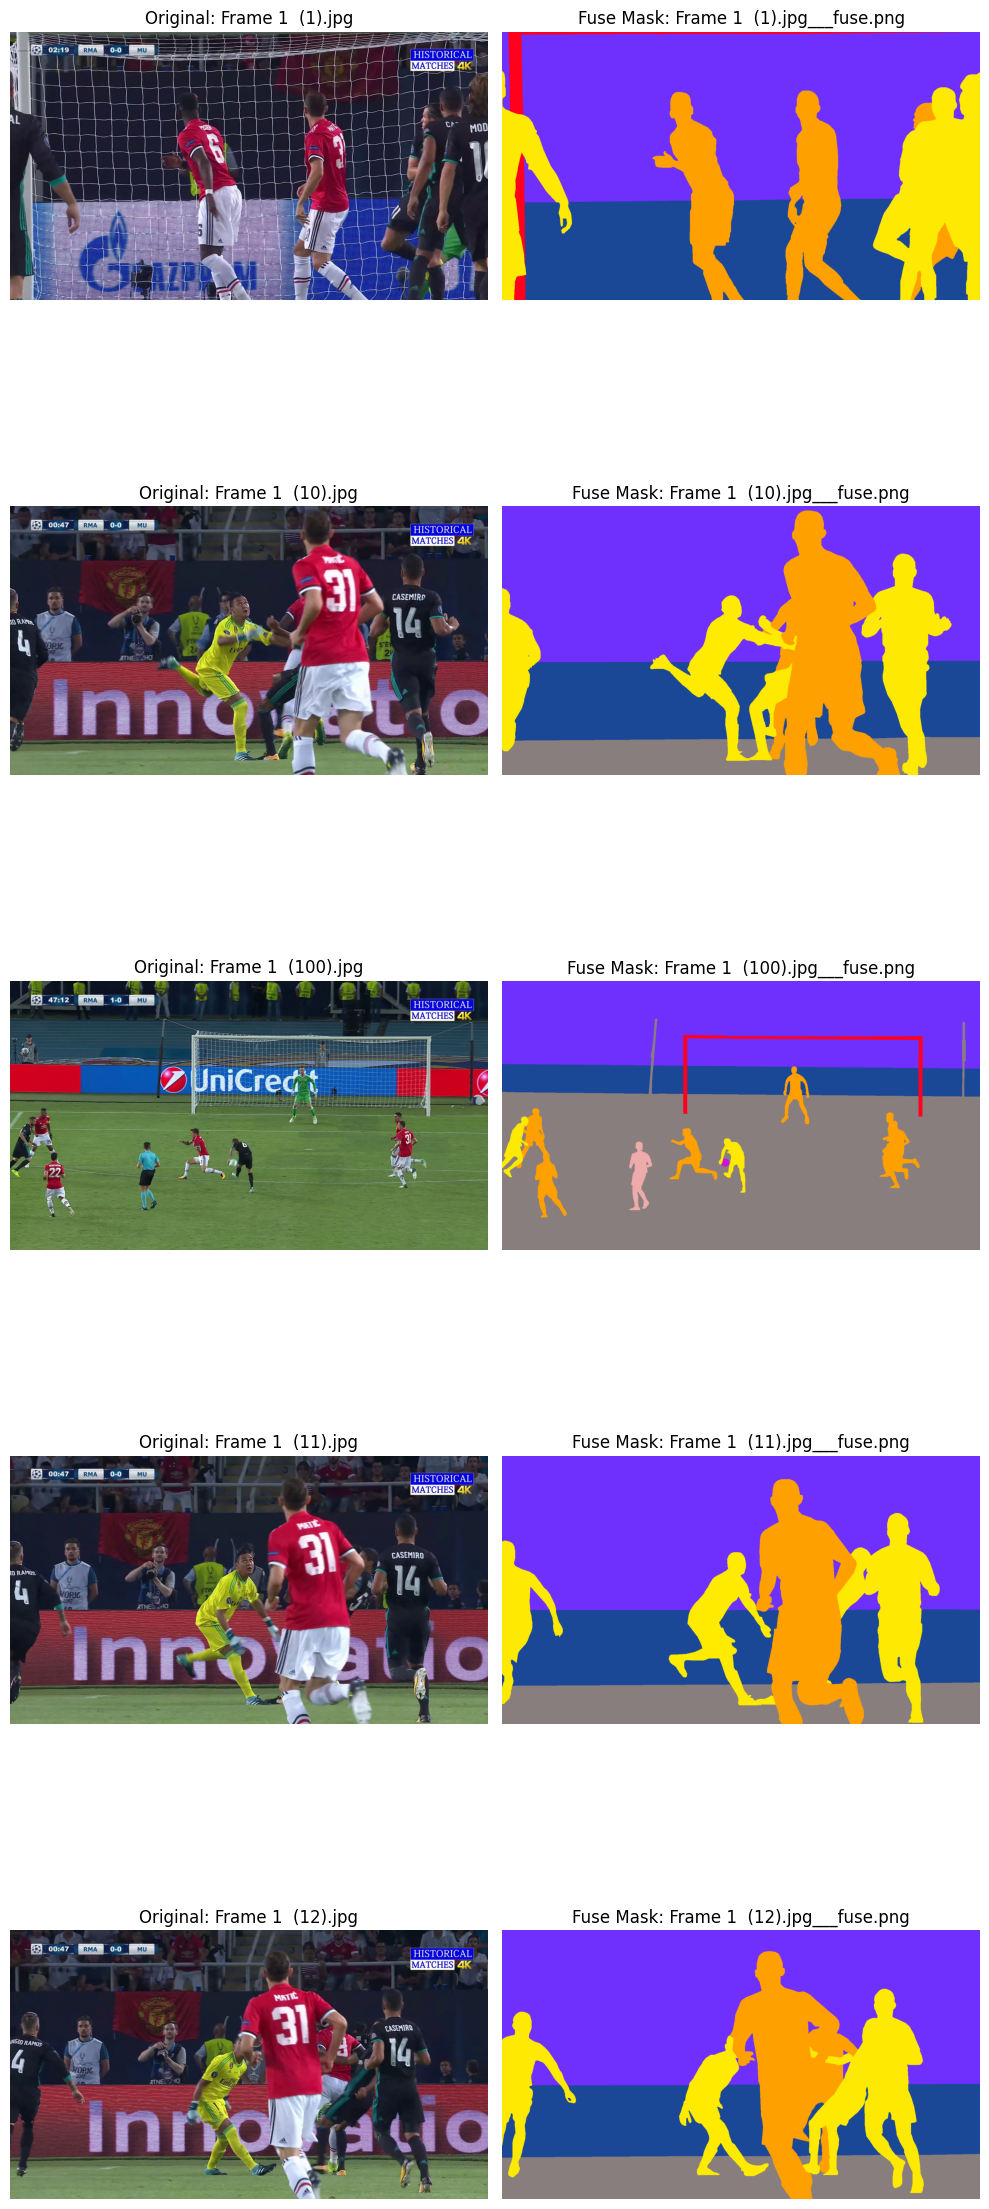

In [23]:
# ============================================
# 매칭 결과 시각화
# ============================================

sample_image_pairs = []
num_samples = 5

for orig_file in original_files[:num_samples]:
    base_name = orig_file.replace(".jpg", "")
    fuse_file = next((f for f in fuse_files if base_name in f), None)

    if fuse_file:
        sample_image_pairs.append((orig_file, fuse_file))

# 이미지 5쌍 시각화
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

for i, (orig_file, fuse_file) in enumerate(sample_image_pairs):
    # 이미지 로드
    orig_img = cv2.imread(os.path.join(image_folder, orig_file))
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)  # OpenCV BGR → RGB 변환

    fuse_img = cv2.imread(os.path.join(image_folder, fuse_file))
    fuse_img = cv2.cvtColor(fuse_img, cv2.COLOR_BGR2RGB)  # 마스크도 RGB 변환

    # 시각화
    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title(f"Original: {orig_file}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(fuse_img)
    axes[i, 1].set_title(f"Fuse Mask: {fuse_file}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [24]:
# ============================================
# Transform 정의 (Albumentations)
# ============================================
import albumentations as A
# Transform 정의
train_transform = A.Compose([
    # 기하학적 변환 (이미지 + 마스크 동시)
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit = 0.1,
        rotate_limit= 10,
        p=0.3
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.2,
        contrast_limit=0.2,
        p=0.5
    ),
    A.HueSaturationValue(
        hue_shift_limit=10,
        sat_shift_limit=20,
        val_shift_limit=10,
        p=0.3
    ),
])

test_transform  = None # 증강 없음

/home/w00sh/miniconda3/envs/pytorch_gpu_wsl/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [25]:
# ============================================
# Dataset 생성
# ============================================

# 증강 적용
train_full_dataset = FootballDataset(
    image_files=original_files,
    mask_files= fuse_files,
    image_folder=image_folder,
    color_to_label=color_to_label,
    transform=train_transform,
    target_size=(256,256),
    verify_mapping=True
)

# 증강없음
test_full_dataset = FootballDataset(
    image_files=original_files,
    mask_files=fuse_files,
    image_folder=image_folder,
    color_to_label=color_to_label,
    transform=test_transform,
    target_size=(256, 256),
    verify_mapping=False 
)

In [26]:
# ============================================
# Train/Test 분할
# ============================================

torch.manual_seed(42)
total_size = len(original_files)
indices = list(range(total_size))
random.shuffle(indices)

train_size = int(0.8 * total_size)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

from torch.utils.data import Subset
train_dataset = Subset(train_full_dataset, train_indices)
test_dataset = Subset(test_full_dataset, test_indices)

In [27]:
# ============================================
# DataLoader 생성
# ============================================

train_loader = DataLoader(
    train_dataset, batch_size=8, shuffle=True,
    num_workers=0,pin_memory=True
    )
test_loader = DataLoader(
    test_dataset, batch_size=8, shuffle=False,
    num_workers=0, pin_memory=True)

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")
print(f"Train Batches: {len(train_loader)}, Test Batches: {len(test_loader)}")

Train: 80, Test: 20
Train Batches: 10, Test Batches: 3


In [28]:
# ============================================
# 모델 생성 및 확인
# ============================================

# 클래스 개수 확인
num_classes = len(color_to_label)
print(f"클래스 개수: {num_classes}")

# 모델 생성
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=3, n_classes=num_classes).to(device)

print(f"사용 디바이스: {device}")
print(f"모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")

# 모델 테스트 (dummy input)
dummy_input = torch.randn(1, 3, 256, 256).to(device)
with torch.no_grad():
    output = model(dummy_input)
    print(f"입력 shape: {dummy_input.shape}")
    print(f"출력 shape: {output.shape}")  # (1, num_classes, 256, 256)

클래스 개수: 11
사용 디바이스: cuda
모델 파라미터 수: 31,044,171
입력 shape: torch.Size([1, 3, 256, 256])
출력 shape: torch.Size([1, 11, 256, 256])


In [29]:
# 가중치 계산
class_weights = calculate_class_weights(train_loader, num_classes, device)
print("클래스 가중치:", class_weights)

클래스 가중치: tensor([0., nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.], device='cuda:0')


클래스 가중치: tensor([0., nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.], device='cuda:0')

클래스 가중치 문제의 원인 예측

1. 실제 마스크에는 11개의 클래스가 없고 2개만 있다
2. 색상 매핑이 잘못되어 대부분의 색이 class 0 으로 변환되고 있다.
3. LUT 변환 과정에서 문제가 있을 수 있다.

원인을 진단하기 위해

1. **마스크 확인**

2. **색상 매핑 확인**

3. **NaN 처리된 Class Weight 계산 함수를 수정해보겠습니다.**

In [31]:
# ============================================
# 마스크 분석: 실제 사용되는 클래스 확인
# ============================================

print("마스크 분석 시작...")

# 모든 마스크에서 실제 사용되는 라벨 확인
all_labels = set()

for images, masks in train_loader:
    unique_labels = torch.unique(masks).cpu().numpy()
    all_labels.update(unique_labels)

print(f"\n실제 데이터에 존재하는 클래스: {sorted(all_labels)}")
print(f"총 {len(all_labels)}개 클래스 발견")

# 클래스별 픽셀 수 상세 분석
class_pixel_counts = torch.zeros(num_classes)

for images, masks in train_loader:
    for c in range(num_classes):
        class_pixel_counts[c] += (masks == c).sum().item()

print("\n클래스별 픽셀 수:")
for c in range(num_classes):
    if class_pixel_counts[c] > 0:
        print(f"  Class {c}: {class_pixel_counts[c]:,.0f} pixels")
    else:
        print(f"  Class {c}: 0 pixels")

마스크 분석 시작...

실제 데이터에 존재하는 클래스: [np.int64(0), np.int64(10)]
총 2개 클래스 발견

클래스별 픽셀 수:
  Class 0: 5,047,828 pixels
  Class 1: 0 pixels
  Class 2: 0 pixels
  Class 3: 0 pixels
  Class 4: 0 pixels
  Class 5: 0 pixels
  Class 6: 0 pixels
  Class 7: 0 pixels
  Class 8: 0 pixels
  Class 9: 0 pixels
  Class 10: 195,052 pixels


마스크에 2개 클래스만 존재하고 있었습니다.

데이터 변환 과정에서 문제가 있다는 의미이니 원인 분석 디버깅을 진행합니다.

#### 디버깅 과정

1. **실제 마스크 색상 확인**

2. **2. 여러 마스크 파일 샘플링 확인**

3. **3. FootballDataset의 변환 과정 디버깅**

4. **4. LUT 직접 테스트**

In [32]:
# ============================================
# 실제 마스크의 RGB 색상 확인
# ============================================

print("첫 번째 마스크 파일의 색상 분석...")

# 첫 번째 마스크 로드
sample_mask_path = os.path.join(image_folder, fuse_files[0])
sample_mask = cv2.imread(sample_mask_path)
sample_mask = cv2.cvtColor(sample_mask, cv2.COLOR_BGR2RGB)

# 고유 색상 추출
unique_colors = np.unique(sample_mask.reshape(-1, 3), axis=0)

print(f"\n실제 마스크에 있는 고유 색상 개수: {len(unique_colors)}")
print("\n고유 색상 리스트:")
for i, color in enumerate(unique_colors):
    color_tuple = tuple(int(c) for c in color)
    pixel_count = np.sum(np.all(sample_mask == color, axis=2))
    print(f"  색상 {i}: {color_tuple} - {pixel_count:,} pixels")

print("\n정의된 color_to_label 매핑:")
for color, label in sorted(color_to_label.items(), key=lambda x: x[1]):
    print(f"  라벨 {label}: {color}")

첫 번째 마스크 파일의 색상 분석...

실제 마스크에 있는 고유 색상 개수: 6

고유 색상 리스트:
  색상 0: (27, 71, 151) - 489,784 pixels
  색상 1: (111, 48, 253) - 958,857 pixels
  색상 2: (254, 233, 3) - 316,652 pixels
  색상 3: (255, 0, 29) - 50,976 pixels
  색상 4: (255, 159, 0) - 17,088 pixels
  색상 5: (255, 160, 1) - 240,243 pixels

정의된 color_to_label 매핑:
  라벨 0: (np.uint8(0), np.uint8(0), np.uint8(0))
  라벨 1: (np.uint8(27), np.uint8(71), np.uint8(151))
  라벨 2: (np.uint8(111), np.uint8(48), np.uint8(253))
  라벨 3: (np.uint8(137), np.uint8(126), np.uint8(126))
  라벨 4: (np.uint8(201), np.uint8(19), np.uint8(223))
  라벨 5: (np.uint8(238), np.uint8(171), np.uint8(171))
  라벨 6: (np.uint8(254), np.uint8(233), np.uint8(3))
  라벨 7: (np.uint8(255), np.uint8(0), np.uint8(29))
  라벨 8: (np.uint8(255), np.uint8(159), np.uint8(0))
  라벨 9: (np.uint8(255), np.uint8(160), np.uint8(1))
  라벨 10: (np.uint8(255), np.uint8(235), np.uint8(0))


In [33]:
# ============================================
# 여러 마스크 파일에서 색상 확인
# ============================================

print("\n여러 마스크 파일 분석 (처음 10개)...")

all_colors_in_dataset = set()

for mask_file in fuse_files[:10]:
    mask_path = os.path.join(image_folder, mask_file)
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    unique_colors = np.unique(mask.reshape(-1, 3), axis=0)
    
    for color in unique_colors:
        all_colors_in_dataset.add(tuple(int(c) for c in color))

print(f"\n처음 10개 마스크의 전체 고유 색상: {len(all_colors_in_dataset)}개")
print("\n발견된 색상:")
for color in sorted(all_colors_in_dataset):
    if color in color_to_label:
        print(f"  {color} → 라벨 {color_to_label[color]} ✓")
    else:
        print(f"  {color} → 매핑 없음")


여러 마스크 파일 분석 (처음 10개)...

처음 10개 마스크의 전체 고유 색상: 11개

발견된 색상:
  (0, 0, 0) → 라벨 0 ✓
  (27, 71, 151) → 라벨 1 ✓
  (111, 48, 253) → 라벨 2 ✓
  (137, 126, 126) → 라벨 3 ✓
  (201, 19, 223) → 라벨 4 ✓
  (238, 171, 171) → 라벨 5 ✓
  (254, 233, 3) → 라벨 6 ✓
  (255, 0, 29) → 라벨 7 ✓
  (255, 159, 0) → 라벨 8 ✓
  (255, 160, 1) → 라벨 9 ✓
  (255, 235, 0) → 라벨 10 ✓


In [34]:
# ============================================
# Dataset의 변환 과정 직접 확인
# ============================================

print("\nDataset 변환 과정 테스트...")

# 첫 번째 샘플 가져오기
test_dataset = FootballDataset(
    image_files=original_files[:1],
    mask_files=fuse_files[:1],
    image_folder=image_folder,
    color_to_label=color_to_label,
    transform=None,
    target_size=(256, 256),
    verify_mapping=False
)

# 원본 마스크 로드
mask_path = os.path.join(image_folder, fuse_files[0])
original_mask = cv2.imread(mask_path)
original_mask = cv2.cvtColor(original_mask, cv2.COLOR_BGR2RGB)
original_mask = cv2.resize(original_mask, (256, 256), interpolation=cv2.INTER_NEAREST)

print(f"\n원본 마스크 고유 색상: {len(np.unique(original_mask.reshape(-1, 3), axis=0))}개")

# Dataset에서 변환된 마스크 가져오기
_, converted_mask = test_dataset[0]
converted_mask_np = converted_mask.numpy()

print(f"변환된 마스크 고유 라벨: {np.unique(converted_mask_np)}")

# 각 라벨의 픽셀 수
for label in np.unique(converted_mask_np):
    count = np.sum(converted_mask_np == label)
    print(f"  라벨 {label}: {count:,} pixels")


Dataset 변환 과정 테스트...

원본 마스크 고유 색상: 6개
변환된 마스크 고유 라벨: [0]
  라벨 0: 65,536 pixels


In [35]:
# ============================================
# LUT 매핑 테스트
# ============================================

print("\nLUT 매핑 테스트...")

# 원본 마스크의 첫 번째 픽셀 10개 테스트
sample_mask_path = os.path.join(image_folder, fuse_files[0])
sample_mask = cv2.imread(sample_mask_path)
sample_mask = cv2.cvtColor(sample_mask, cv2.COLOR_BGR2RGB)
sample_mask = cv2.resize(sample_mask, (256, 256), interpolation=cv2.INTER_NEAREST)

# 샘플 픽셀들
sample_pixels = sample_mask[:10, :10].reshape(-1, 3)

print("\n샘플 픽셀 10개의 RGB → 라벨 변환:")
for i, pixel in enumerate(sample_pixels[:10]):
    rgb = tuple(int(c) for c in pixel)
    
    # LUT 사용한 변환
    key = (pixel[0] << 16) | (pixel[1] << 8) | pixel[2]
    label_from_lut = test_dataset.LUT[key] if hasattr(test_dataset, 'LUT') else -999
    
    # 직접 매핑 확인
    label_from_dict = color_to_label.get(rgb, -1)
    
    print(f"  픽셀 {i}: RGB {rgb}")
    print(f"    → LUT: {label_from_lut}")
    print(f"    → Dict: {label_from_dict}")


LUT 매핑 테스트...

샘플 픽셀 10개의 RGB → 라벨 변환:
  픽셀 0: RGB (111, 48, 253)
    → LUT: 2
    → Dict: 2
  픽셀 1: RGB (111, 48, 253)
    → LUT: 2
    → Dict: 2
  픽셀 2: RGB (111, 48, 253)
    → LUT: 2
    → Dict: 2
  픽셀 3: RGB (111, 48, 253)
    → LUT: 2
    → Dict: 2
  픽셀 4: RGB (255, 0, 29)
    → LUT: 7
    → Dict: 7
  픽셀 5: RGB (255, 0, 29)
    → LUT: 7
    → Dict: 7
  픽셀 6: RGB (255, 0, 29)
    → LUT: 7
    → Dict: 7
  픽셀 7: RGB (255, 0, 29)
    → LUT: 7
    → Dict: 7
  픽셀 8: RGB (255, 0, 29)
    → LUT: 7
    → Dict: 7
  픽셀 9: RGB (255, 0, 29)
    → LUT: 7
    → Dict: 7


#### 디버깅 결과 

1. **실제 마스크 색상 확인** 
: 원본 마스크에는 6개의 색상이 있고, 이 색상들은 color_to_label 매핑에 모두 존재합니다.

2. **2. 여러 마스크 파일 샘플링 확인**
: 10개 마스크 파일 전체에 11개 클래스가 모두 존재합니다.

3. **3. FootballDataset의 변환 과정 디버깅**
- 원본 마스크 : 6개 색상
- 변환된 마스크 [0] 
- 변환 과정에서 모든 픽셀이 라벨 0으로 변환되고 있다는걸 시사합니다.

4. **4. LUT 직접 테스트**
: LUT 자체는 제대로 작동합니다.

`class FootballDataset` 에 문제가 있을것으로 보입니다.

`color_to_label` 의 key 값이 `(np.uint8(27), np.uint8(71), np.uint8(151))` 형태인데, 실제 마스크 데이터는 `(27,71,151)` 형태입니다.

확인 결과 `np.uint8` 로 만든 `rgb` 튜플을 그대로 `<<` 연산에 쓰면 안된다고 합니다.

Python 정수 vs. NumPy 스칼라  

|                     | Python `int`                     | NumPy 스칼라 (`np.uint8`, `np.int32` …) |
|---------------------|----------------------------------|------------------------------------------|
| 비트 폭               | **가변** (무한히 큰 정밀도)      | **고정** (예: `uint8` → 8 bit, `uint32` → 32 bit) |
| 연산 시 자동 캐스팅   | 연산 중에 필요하면 **자동** up‑cast (예: `27 << 16` → Python `int` = 1 769 472) | 연산 결과는 **입력 dtype** 로 강제 캐스팅. `np.left_shift(np.uint8(27), 16)` → `np.uint8(0)` (overflow) |
| 연산 정의 (u‑func)    | 파이썬 내장 연산자 (C‑level `long` 사용, overflow 없음) | NumPy u‑func (`np.left_shift`, `np.right_shift`, `np.bitwise_and`, …) 는 **dtype‑aware** 로 동작 |

**핵심**: `np.uint8` 은 8 bit 정수이기 때문에 8 bit 를 초과하는 비트 이동을 하면 **버려진다(overflow)**.  
따라서 `np.uint8(27) << 16` 은 `0` 로 변환됩니다. 같은 이유로 `np.uint8(71) << 8` 은 `0`, `np.uint8(151)` 은 그대로 `151`. 최종 OR 연산도 `0 | 0 | 151 = 151` 로, **색을 구분할 수 없는 값**(실제 색값이 아니라 0~255 범위 안에 머무는 값) 이 됩니다.

**결과**: `np.uint8` 로 만든 색을 그대로 비트‑패킹 하면 **키가 0 혹은 151 같은 작은 값**만 남아, LUT 에서 거의 모든 색이 같은 키(보통 0) 로 매핑됩니다. 그 결과 `mask_class == 0` 이 되면서 **모든 픽셀이 라벨 0** 으로 변환되는 현상이 발생합니다.


```python
key = (rgb[0] << 16) | (rgb[1] << 8) | rgb[2] # Error
```
`_create_lut()` 수정하겠습니다.

In [30]:
# ============================================
# 학습 시작
# ============================================

# 학습 실행
trained_model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    num_classes=num_classes,
    device=device,
    num_epochs=50,
    lr=0.001,
    patience=7,
    model_name='football_unet',
    class_weights=class_weights
)

print("\n학습 완료!")

/home/w00sh/miniconda3/envs/pytorch_gpu_wsl/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/50


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


Train Loss: nan | mIoU: 0.0000 | Pixel Acc: 0.0000
Val   Loss: nan | mIoU: 0.0011 | Pixel Acc: 0.0124
Validation mIoU increased (0.0011). Saving model...

Epoch 2/50


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Train Loss: nan | mIoU: 0.0000 | Pixel Acc: 0.0000
Val   Loss: nan | mIoU: 0.0011 | Pixel Acc: 0.0124
Validation mIoU increased (0.0011). Saving model...

Epoch 3/50


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]


Train Loss: nan | mIoU: 0.0000 | Pixel Acc: 0.0000
Val   Loss: nan | mIoU: 0.0011 | Pixel Acc: 0.0124
Validation mIoU increased (0.0011). Saving model...

Epoch 4/50


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Train Loss: nan | mIoU: 0.0019 | Pixel Acc: 0.0004
Val   Loss: nan | mIoU: 0.0011 | Pixel Acc: 0.0124
Validation mIoU increased (0.0011). Saving model...

Epoch 5/50


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Train Loss: nan | mIoU: 0.0035 | Pixel Acc: 0.0005
Val   Loss: nan | mIoU: 0.0011 | Pixel Acc: 0.0124
Validation mIoU increased (0.0011). Saving model...

Epoch 6/50


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


Train Loss: nan | mIoU: 0.0023 | Pixel Acc: 0.0010
Val   Loss: nan | mIoU: 0.0011 | Pixel Acc: 0.0124
Validation mIoU increased (0.0011). Saving model...

Epoch 7/50


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


Train Loss: nan | mIoU: 0.0030 | Pixel Acc: 0.0014
Val   Loss: nan | mIoU: 0.0011 | Pixel Acc: 0.0124
Validation mIoU increased (0.0011). Saving model...

Epoch 8/50


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


Train Loss: nan | mIoU: 0.0030 | Pixel Acc: 0.0024
Val   Loss: nan | mIoU: 0.0011 | Pixel Acc: 0.0124
Validation mIoU increased (0.0011). Saving model...

Epoch 9/50


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


Train Loss: nan | mIoU: 0.0060 | Pixel Acc: 0.0054
Val   Loss: nan | mIoU: 0.0011 | Pixel Acc: 0.0124
Validation mIoU increased (0.0011). Saving model...

Epoch 10/50


Validation:  20%|██        | 2/10 [00:01<00:06,  1.21it/s]


KeyboardInterrupt: 

#### 학습 시작 혹은 모델 불러오기

In [ ]:
# ============================================
# 모델 불러오기
# ============================================

# 전체 파이프라인 설정
model, device, color_to_label, test_loader, label_to_color = setup_inference_pipeline(
    data_path='./data/images',  # 데이터 경로 수정
    color_mapping_path='color_mapping.json',
    model_path='football_unet_best.pt'  # 저장한 모델 파일명
)

print("\n추론 준비 완료! 이제 검증 및 시각화를 진행할 수 있습니다.")

In [ ]:
# ============================================
# 학습 곡선 및 성능 평가
# ============================================

print("\n" + "="*60)
print("모델 성능 평가 및 시각화 시작")
print("="*60)

# 1. 학습 곡선 시각화 (history가 있는 경우)
if 'history' in locals():
    print("\n학습 곡선 시각화...")
    plot_training_curves(history, save_path='training_curves.png')
else:
    print("\n경고: history 객체가 없습니다. 학습 곡선을 건너뜁니다.")

# 2. 성능 평가
print("\n모델 성능 평가...")
num_classes = len(color_to_label)
metrics = evaluate_model(model, test_loader, device, num_classes)

print("\n전체 성능:")
print("="*40)
print(f"Pixel Accuracy: {metrics['pixel_accuracy']:.4f}")
print(f"Mean IoU (mIoU): {metrics['miou']:.4f}")
print(f"Dice Score: {metrics['dice']:.4f}")
print("="*40)

# 3. 클래스별 성능 시각화
print("\n클래스별 성능 시각화...")
plot_class_performance(metrics, color_to_label, save_path='class_performance.png')

# 4. 예측 결과 시각화 (5개 샘플)
print("\n예측 결과 시각화...")
visualize_predictions(model, test_loader, device, label_to_color, num_samples=4, save_path='predictions.png')

# 5. 오버레이 시각화 (3개 샘플)
print("\n오버레이 시각화...")
visualize_overlay(model, test_loader, device, label_to_color, num_samples=3, alpha=0.6, save_path='overlay.png')

print("\n" + "="*60)
print("검증 및 시각화 완료!")
print("="*60)